# Dr. Simonson Chronic Mountain Sickness 

# RNASeq Data Exploration and Pre-Processing

   > * Art Nasamran, CCBB (cnasamran@ucsd.edu)
   > * Based on upstream analysis by Guorong Xu, CCBB (g1xu@ucsd.edu)

* Modeled on "RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR" ([1](#Citations))

## Table of Contents
* [Background](#Background)
* [Parameter Input](#Parameter-Input)
* [Library Import](#Library-Import)
* [Data Import](#Data-Import)
* [Data Exploration](#Data-Exploration)
* [Pre-Processing](#Pre-Processing)
    * [Scale Transformation and Lowly-Expressed Genes Filtration](#Scale-Transformation-and-Lowly-Expressed-Genes-Filtration)
    * [Normalization](#Normalization)
* [Unsupervised Clustering](#Unsupervised-Clustering)
* [Summary](#Summary)
* [Citations](#Citations)
* [Appendix: R Session Info](#Appendix:-R-Session-Info)


## Introduction

This notebook takes in RNASeq data prepared by the previous notebook, "RNASeq_Count_Metadata_Annotation_Load_and_Integration", and uses the limma ([2](#Citations)) and edgeR ([3](#Citations)) Bioconductor ([4](#Citations)) packages written in R ([5](#Citations)) to explore these data and pre-process them in preparation for differential expression testing.

<div class="alert alert-info">

In order for the plots in this notebook to display correctly, it is critical that the `pandoc` software package ([https://pandoc.org/index.html](https://pandoc.org/index.html)) be installed.  `pandoc` can be installed through `conda` or with `pandoc`'s own installer.  Ensure `pandoc` is installed (for instance, by running `pandoc -v` from the command line and ensuring this returns the installed `pandoc` version) before running this notebook.
        
</div>

[Table of Contents](#Table-of-Contents)

## Parameter Input

In [1]:
gPreviousStepRdataFp = "../interim/20191108_simonson_rnaseq_data_integration_20200213120626.RData"

In [2]:
gSourceDir = "./src/"
# Import shared source code to load and save previous notebooks' environments:
source(paste0(gSourceDir, "ChainedNotebookSupport.R"))
# Import the previous step's state:
gPreviousStepEnv = loadToEnvironment(gPreviousStepRdataFp)

In [3]:
# Load relevant variables:
gProjectName = gPreviousStepEnv$gProjectName
gInterimDir = gPreviousStepEnv$gInterimDir
gOutputDir = gPreviousStepEnv$gOutputDir
gDgeList = gPreviousStepEnv$gDgeList
gGeneType = gPreviousStepEnv$gGeneType
gGeneIdCol = gPreviousStepEnv$gGeneIdCol

Populate the run name parameter automatically to ensure that outputs from different runs do not overwrite each other:

In [4]:
gRunName = makeRunName(gProjectName, "data_exploration")
gRunName

[1] "20191108_simonson_rnaseq_data_exploration_20200218092250"

[Table of Contents](#Table-of-Contents)

## Library Import

Import the necessary R, Bioconductor, and CCBB libraries for the analysis:

In [5]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

In [6]:
# BiocManager::install("limma")

In [7]:
# BiocManager::install("edgeR")

In [8]:
# BiocManager::install("Glimma")

In [9]:
# install.packages("gdata")

In [10]:
# install.packages("cowplot")

In [11]:
# install.packages("gplots")

In [5]:
library(limma)
library(edgeR)
library(Glimma)

In [6]:
library(IRdisplay)

In [7]:
source(paste0(gSourceDir, "PcaPlotter.R"))
source(paste0(gSourceDir, "CountsPcaPlotter.R"))


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [8]:
# This line prevents SVG output, which interacts badly with export to HTML
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

[Table of Contents](#Table-of-Contents)

## Data Examination

### Library Size Visualization

Examine the characteristics of the raw reads for protein coding genes:

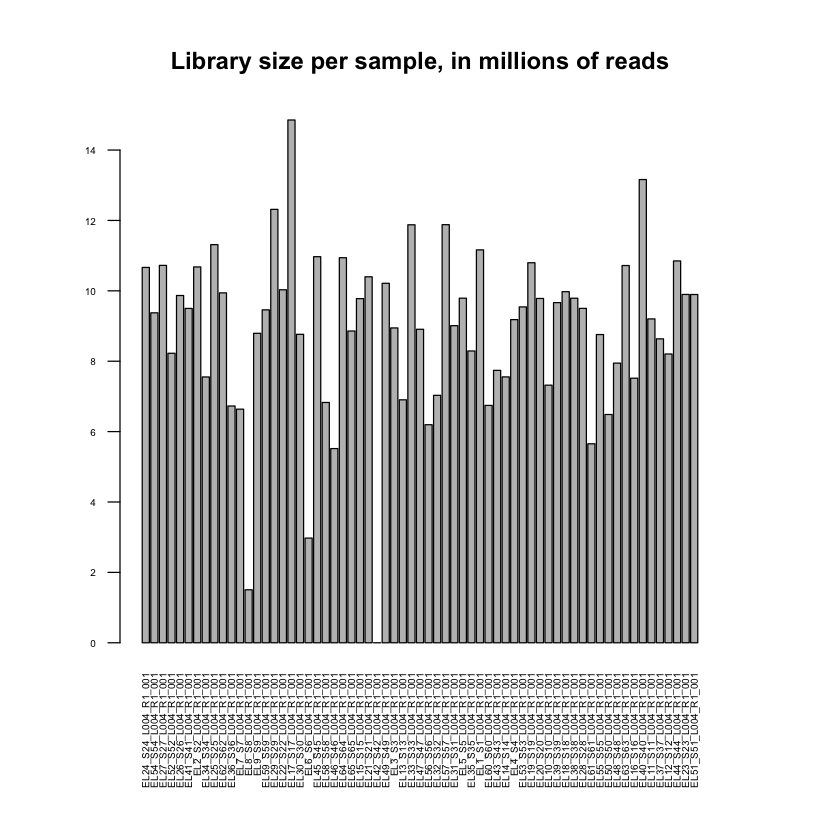

In [9]:
#Plot library size in millions of reads for each sample
par(mar=c(8,5,5,5), cex.axis=0.5)
options(scipen=-1)
barplot(gDgeList$samples$lib.size/1000000, horiz=F, names.arg=colnames(gDgeList$counts), las=2,
       main="Library size per sample, in millions of reads")

> These numbers are somewhat small, given that the raw fastq files for the samples contained 15.9 to 32.1 million reads each (see primary analysis); the researchers may wish to investigate the cause for this attrition. However, some of these library sizes should be adequate to give gene-level differential expression findings. 

### Removal of Low-Alignment Samples

In [10]:
gSamplesToKeepMask = gDgeList$samples$lib.size > 6000000 
length(gDgeList$samples$lib.size)
sum(gSamplesToKeepMask==TRUE)

[1] 65

[1] 60

In [11]:
gSampleFilteredDgeList = gDgeList[,gSamplesToKeepMask]
dim(gSampleFilteredDgeList)

[1] 19922    60

> 5 samples with <6M reads were removed.

### Raw Counts Visualization

Next, perform and examine a principal components analysis of the **raw** data:

In [12]:
doRawCountsPca = function(dgeList, sampleNameMetadataCol, shapeMetadataCol, labelsMetadataCol){
    makeAndPrintRawCountsPca(data.frame(dgeList$counts, check.names=FALSE), dgeList$samples, shapeMetadataCol,
                             sampleNameMetadataCol, designColNameForLabels=labelsMetadataCol, 
                             labelOnlyOutliers=FALSE)   
}

In [13]:
colnames(gDgeList$samples)

[1] "group"               "lib.size"            "norm.factors"       
 [4] "File_Name"           "Sample_name"         "Sample_ID"          
 [7] "Patient"             "Condition"           "Treatment"          
[10] "Condition_Treatment" "Tissue"              "Date_Collected"     
[13] "Physio_State"        "Treatment.1"         "Pass_QC"            
[16] "cpf_include"

In [14]:
# Sample identifier
gSampleColName = "Sample_name"

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
Standard deviation,82.46580,38.25105,31.58001,28.86845,23.68179,21.72914,21.48709,19.54387,19.45152,17.92217,⋯,9.288329,9.237153,9.123881,9.088147,8.858395,8.847792,8.693106,7.98496,7.641461,1.953582e-13
Proportion of Variance,0.35053,0.07542,0.05140,0.04296,0.02891,0.02434,0.02380,0.01969,0.01950,0.01656,⋯,0.004450,0.004400,0.004290,0.004260,0.004040,0.004040,0.003900,0.00329,0.003010,0.000000e+00
Cumulative Proportion,0.35053,0.42594,0.47735,0.52030,0.54921,0.57355,0.59735,0.61703,0.63654,0.65309,⋯,0.968780,0.973180,0.977470,0.981730,0.985770,0.989810,0.993700,0.99699,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


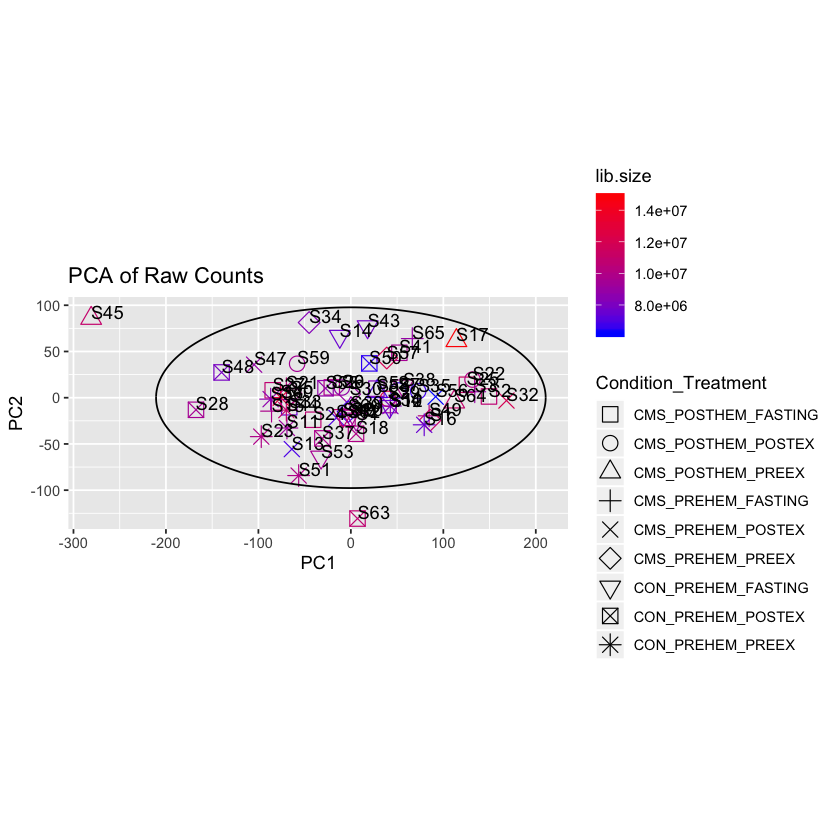

In [15]:
doRawCountsPca(gSampleFilteredDgeList, gSampleColName, "Condition_Treatment", "Sample_ID")

Examine how many genes are missing from the reads found in samples (those for which it is TRUE that they are NOT expressed in any sample):

In [16]:
table(rowSums(gSampleFilteredDgeList$counts==0)==nrow(gSampleFilteredDgeList$samples))


FALSE  TRUE 
19401   521 


   > Approximately 521 of the genes in the dataset are missing from reads found in samples (that is, not found to be expressed in any of the samples). 

[Table of Contents](#Table-of-Contents)

## Pre-Processing

### Scale Transformation and Lowly-Expressed Genes Filtration

> For differential expression and related analyses, gene expression is rarely considered at the level of raw counts since libraries sequenced at a greater depth will result in higher counts. Rather, it is common practice to transform raw counts onto a scale that accounts for such library size differences. Popular transformations include counts per million (CPM), log2-counts per million (log-CPM), reads per kilobase of transcript per million (RPKM), and fragments per kilobase of transcript per million (FPKM).
>
> In our analyses, CPM and log-CPM transformations are used regularly although they do not account for feature length differences which RPKM and FPKM values do. Whilst RPKM and FPKM values can just as well be used, CPM and log-CPM values can be calculated using a counts matrix alone and will suffice for the type of comparisons we are interested in. Assuming that there are no differences in isoform usage between conditions, differential expression analyses look at gene expression changes between conditions rather than comparing expression across multiple genes or drawing conclusions on absolute levels of expression. In other words, gene lengths remain constant for comparisons of interest and any observed differences are a result of changes in condition rather than changes in gene length.
>
> Here raw counts are converted to CPM and log-CPM values using the cpm function in edgeR, where log-transformations use a prior count of 0.25 to avoid taking the log of zero. RPKM values are just as easily calculated as CPM values using the rpkm function in edgeR if gene lengths are available. ([1](#Citations))

Also, regarding lowly expressed genes:

> All datasets will include a mix of genes that are expressed and those that are not expressed. Whilst it is of interest to examine genes that are expressed in one condition but not in another, some genes are unexpressed throughout all samples....
>
> Genes that are not expressed at a biologically meaningful level in any condition should be discarded to reduce the subset of genes to those that are of interest, and to reduce the number of tests carried out downstream when looking at differential expression. Upon examination of log-CPM values, it can be seen that a large proportion of genes within each sample is unexpressed or lowly-expressed .... Using a nominal CPM value of 1 (which is equivalent to a log-CPM value of 0) genes are deemed to be expressed if their expression is above this threshold, and unexpressed otherwise. Genes must be expressed in at least one group (or in at least [a minimum number of] samples across the entire experiment) to be kept for downstream analysis.
>
> Although any sensible value can be used as the expression cutoff, typically a CPM value of 1 is used in our analyses as it separates expressed genes from unexpressed genes well for most datasets. ... If sequence reads are summarised by exons rather than genes and/or experiments have low sequencing depth, a lower CPM cutoff may be considered. ([1](#Citations))

A filtration threshold of 1 CPM (counts per million) means a gene is considered expressed if it has more than the below number of counts in the sample with the lowest sequencing depth:

In [17]:
# the smallest library size, in millions
min(round(gSampleFilteredDgeList$samples$lib.size))/1000000

[1] 6.195327

Likewise, a filtration threshold of 1 CPM (counts per million) means a gene is considered expressed if it has more than the below number of counts in the sample with the greatest sequencing depth:

In [18]:
# the largest library size, in millions
max(round(gSampleFilteredDgeList$samples$lib.size))/1000000

[1] 14.85378

In [19]:
# Separate blue highlighted samples ("CMS_POSTHEM_FASTING SAMPLES TO INCLUDE") as "CMS_POSTHEM_FASTING_I"
cpf_include.idx <- which(gSampleFilteredDgeList$samples$cpf_include == 1)
gSampleFilteredDgeList$samples$Condition_Treatment[cpf_include.idx] <- rep("CMS_POSTHEM_FASTING_I", length(cpf_include.idx))

In [20]:
table(gSampleFilteredDgeList$samples$Condition_Treatment)


  CMS_POSTHEM_FASTING CMS_POSTHEM_FASTING_I    CMS_POSTHEM_POSTEX 
                    5                     5                     6 
    CMS_POSTHEM_PREEX    CMS_PREHEM_FASTING     CMS_PREHEM_POSTEX 
                    5                     5                     5 
     CMS_PREHEM_PREEX    CON_PREHEM_FASTING     CON_PREHEM_POSTEX 
                    6                     8                     7 
     CON_PREHEM_PREEX 
                    8 


   > Genes having a CPM of greater than 1 for greater than or equal to 5 samples (chosen as this is the smallest group size in this experiment) will be retained for further analysis, while all others will be discarded.


In [21]:
# NB: this must be re-selected each time a new analysis is run
# to ensure these values are appropriate to the data
gMinExclusiveCpms = 1
gMinInclusiveNumSamples = 5

In [22]:
filterDgeListByCpmThresholdForNumSamples = function(aDgeList, minExclusiveCpms, minInclusiveNumSamples){
    cpmsMatrix = cpm(aDgeList)
    keepMask = rowSums(cpmsMatrix>minExclusiveCpms)>=minInclusiveNumSamples
    filteredDgeList = aDgeList[keepMask,, keep.lib.sizes=FALSE]
    return(filteredDgeList)
}

plotLogCpmDensityPrePostFiltering = function(unfilteredDgeList, filteredDgeList, minExclusiveCpmThreshold){
    library(RColorBrewer)
    
    logMinExclusiveCpmThreshold = log(minExclusiveCpmThreshold)
    nsamples <- ncol(unfilteredDgeList)
    unfilteredLogCpmsMatrix = cpm(unfilteredDgeList, log=TRUE)
    col <- brewer.pal(nsamples, "Paired")
    par(mfrow=c(1,2))
    plot(density(unfilteredLogCpmsMatrix[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
         main="", xlab="")
    title(main="A. Raw data", xlab="Log-CPM")
    abline(v=logMinExclusiveCpmThreshold, lty=3)
    for (i in 2:nsamples){
     den <- density(unfilteredLogCpmsMatrix[,i])
     lines(den$x, den$y, col=col[i], lwd=2)
    }
    #legend("topright", colnames(x), text.col=col, bty="n")
    filteredLogCpmsMatrix = cpm(filteredDgeList, log=TRUE)
    plot(density(filteredLogCpmsMatrix[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
         main="", xlab="")
    title(main="B. Filtered data", xlab="Log-CPM")
    abline(v=logMinExclusiveCpmThreshold, lty=3)
    for (i in 2:nsamples){
       den <- density(filteredLogCpmsMatrix[,i])
       lines(den$x, den$y, col=col[i], lwd=2)
    }
}

In [23]:
gFilteredDgeList = filterDgeListByCpmThresholdForNumSamples(gSampleFilteredDgeList, gMinExclusiveCpms, gMinInclusiveNumSamples)

"Note that subsetting the entire DGEList-object removes both the counts as well as the associated gene information." ([1](#Citations))

In [24]:
dim(gSampleFilteredDgeList)
dim(gFilteredDgeList)

[1] 19922    60

[1] 13450    60


   > Discarding lowly expressed genes reduces the number of genes in the dataset from 19922 to 13450.

This removal changes the log-CPM density distribution of the dataset as shown below.

> The density of log-CPM values for raw pre-filtered data (A) and post-filtered data (B) are shown for each sample. Dotted vertical lines mark the **log**-CPM of the [CPM] threshold ... used in the filtering step. ([1](#Citations))


Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

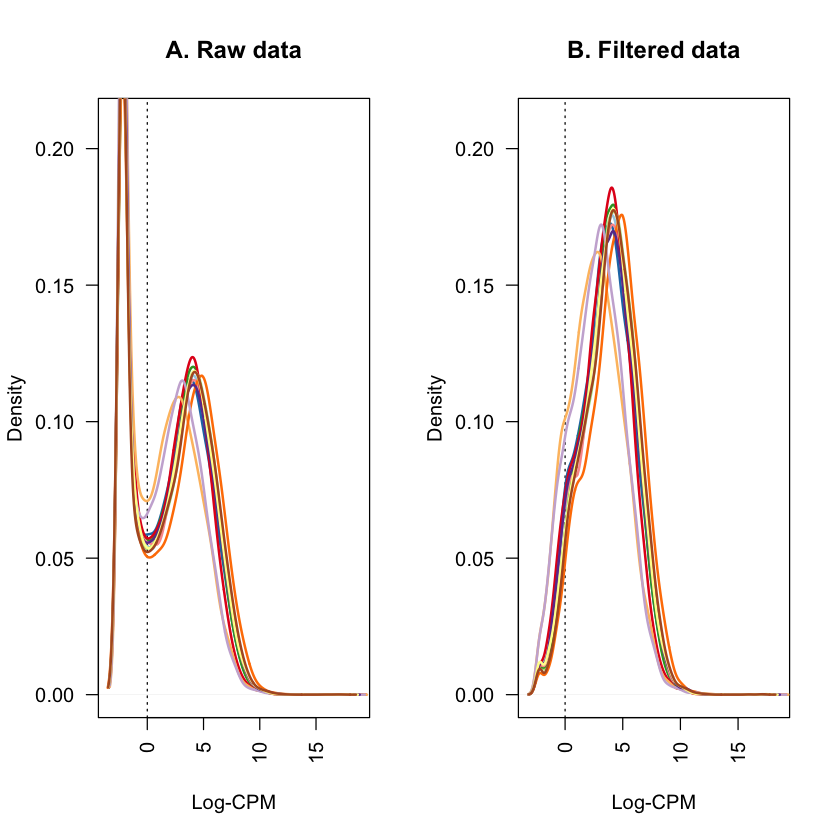

In [25]:
plotLogCpmDensityPrePostFiltering(gSampleFilteredDgeList, gFilteredDgeList, gMinExclusiveCpms)

[Table of Contents](#Table-of-Contents)

### Normalization

> During the sample preparation or sequencing process, external factors that are not of biological interest can affect the expression of individual samples. For example, samples processed in the first batch of an experiment can have higher expression overall when compared to samples processed in a second batch. It is assumed that all samples should have a similar range and distribution of expression values. Normalisation is required to ensure that the expression distributions of each sample are similar across the entire experiment.
>
> Any plot showing the per sample expression distributions, such as a density [such as the log-CPM plot above] or boxplot, is useful in determining whether any samples are dissimilar to others. ([1](#Citations))

Note that normalization is generally applied even when no major per sample expression differences are evident.  It is useful to note that the normalization discussed here is distinct from that performed earlier when raw counts were normalized to counts per million:

> CPM "normalization" accounts for library size differences between samples, and produces normalized values that can be compared on an absolute scale (e.g., for filtering). TMM [see below] normalization accounts for composition bias, and computes normalization factors for comparing between libraries on a relative scale. CPM normalization doesn't account for composition bias, and TMM normalization doesn't produce normalized values. Thus, you need both steps in the analysis pipeline. This isn't a problem, as the two steps aren't really redundant. ([6](#Citations))

Thus, this normalization step accounts for differences in the composition of the RNA populations in different samples, whereas CPM normalization accounts for differences in library size. 

The most common normalizations applied to RNASeq data are TMM (Trimmed Mean of M-values) and RLE (Relative Log Expression, also frequently referred to as DESeq normalization).  Dillies et al 2013 ([7](#Citations)) report that these two methods (and only these two, of the seven normalization methods assessed) "are able to maintain a reasonable false-positive rate without any loss of power", and they find them largely interchangeable.  They also note:

> It is important to keep in mind that most normalization strategies (including DESeq and TMM) rely on the rather strong assumptions that most genes are not differentially expressed, and that for those differentially expressed there is an approximately balanced proportion of over- and under-expression .... Though these assumptions appear reasonable in many studies, including those considered here, there are experiments in which they are not met. Unfortunately, these assumptions are rarely checked in practice; in fact, it would be extremely difficult to do so.

With this in mind, we employ TMM ([8](#Citations)), which is the default for limma and edgeR analyses, unless we have pre-existing knowledge that the tested system is likely to contravene these assumptions.  

> [N]ormalisation by the method of trimmed mean of M-values (TMM) (Robinson and Oshlack 2010) is performed using the calcNormFactors function in edgeR. The normalisation factors calculated here are used as a scaling factor for the library sizes. When working with DGEList-objects, these normalisation factors are automatically stored in x\\$samples\$norm.factors. ([1](#Citations))

Normalize the data to remove effects of library sizes using the trimmed mean of M-values (TMM) approach:

In [26]:
gOrigNormedFilteredDgeList <- calcNormFactors(gFilteredDgeList, method = "TMM")

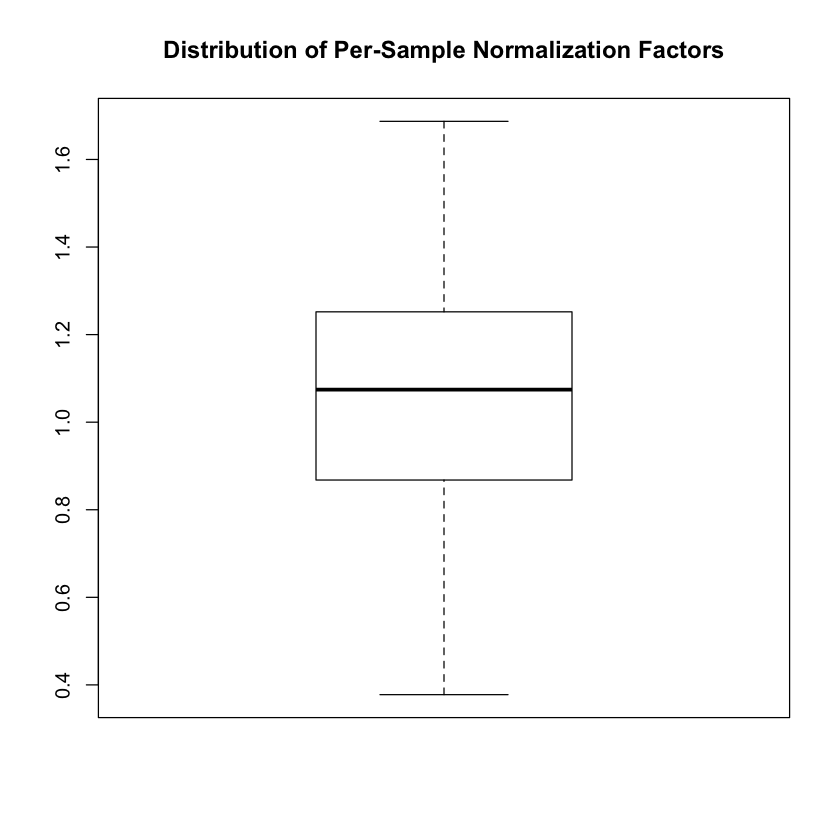

In [27]:
boxplot(gOrigNormedFilteredDgeList$samples$norm.factors, main="Distribution of Per-Sample Normalization Factors")

> The magnitude of the scaling factors, as shown above, is near 1 for most samples, indicating that little normalization is required and the effect of the TMM normalization is mild. However, there are some samples with extreme scaling factors. They may need to be removed after further investigation.


Write out the cpm-transformed, TMM-normalized data for future reference:

In [28]:
writeFilteredCpms = function(dgeList, outputDir, runName, geneType){
    cpm = cpm(dgeList)
    fileName = sprintf("%s_filtered_%s_genes_tmm_normed_cpms.csv",runName, geneType)
    write.csv(cpm, file.path(outputDir, fileName))
    print(paste0("Output file: ",fileName))
}

In [29]:
writeFilteredCpms(gFilteredDgeList, gOutputDir, gRunName, gGeneType)

[1] "Output file: 20191108_simonson_rnaseq_data_exploration_20200218092250_filtered_pc_genes_tmm_normed_cpms.csv"


[Table of Contents](#Table-of-Contents)

## Unsupervised Clustering

> In our opinion, one of the most important exploratory plots to examine for gene expression analyses is the multi-dimensional scaling (MDS) plot, or similar. The plot shows similarities and dissimilarities between samples in an unsupervised manner so that one can have an idea of the extent to which differential expression can be detected before carrying out formal tests. Ideally, samples would cluster well within the primary condition of interest, and any sample straying far from its group could be identified and followed up for sources of error or extra variation. If present, technical replicates should lie very close to one another. ([1](#Citations))

Examine the aggregate similarities between samples using unsupervised clustering, and determine if this unbiased approach shows similarities similar to those expected from the experimental design.  Begin with a principal components analysis of the normalized data.

### Principal Components Analysis

In [30]:
makeNormalizedPca<-function(normedDgeList, designDf, groupColName, sampleColName, 
                            designColNameForLabels=NULL, labelOnlyOutliers=TRUE){
    cpm_matrix = cpm(normedDgeList, normalized.lib.sizes=T)
    cpmDf = data.frame(cpm_matrix)
    title = "PCA of Normalized Counts" 
    makeAndPrintPca(title, cpmDf, designDf, groupColName, sampleColName, 
                    designColNameForLabels=designColNameForLabels, 
                    labelOnlyOutliers=labelOnlyOutliers)    
    return("")
}

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
Standard deviation,53.97383,39.11369,33.35959,26.92051,24.32856,22.06865,19.51781,18.68575,17.62400,17.05809,⋯,7.683032,7.601622,7.520903,7.492968,7.408686,7.335541,7.25416,7.04114,6.876746,6.499882e-14
Proportion of Variance,0.21659,0.11375,0.08274,0.05388,0.04401,0.03621,0.02832,0.02596,0.02309,0.02163,⋯,0.004390,0.004300,0.004210,0.004170,0.004080,0.004000,0.00391,0.00369,0.003520,0.000000e+00
Cumulative Proportion,0.21659,0.33034,0.41308,0.46696,0.51097,0.54718,0.57550,0.60146,0.62455,0.64619,⋯,0.968130,0.972420,0.976630,0.980800,0.984880,0.988890,0.99280,0.99648,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] ""

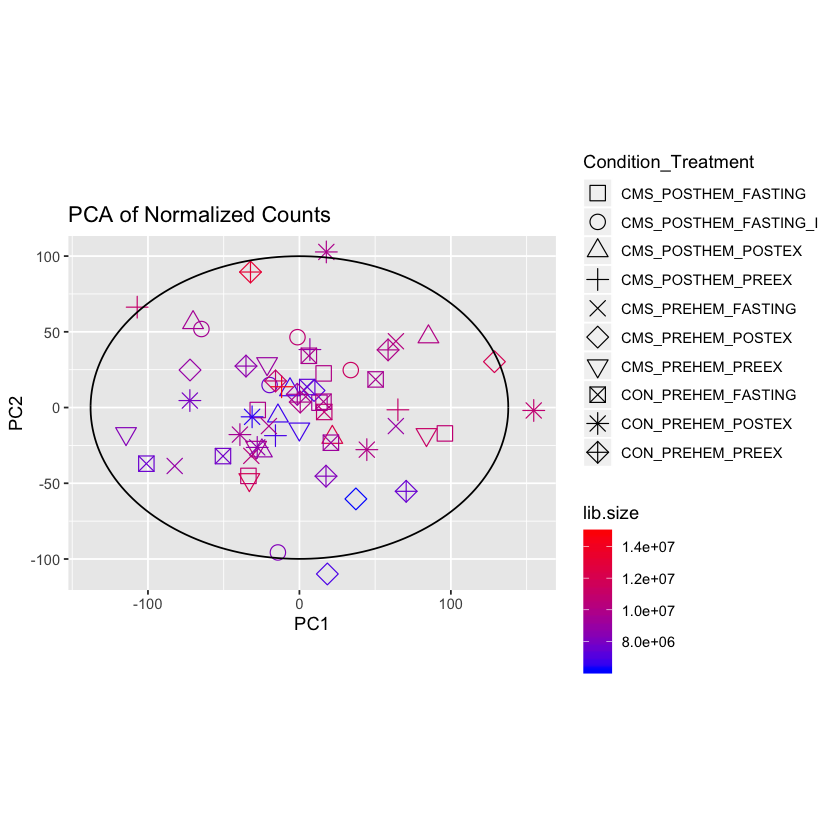

In [31]:
makeNormalizedPca(gOrigNormedFilteredDgeList, gOrigNormedFilteredDgeList$samples, 
                  "Condition_Treatment", gSampleColName)


   > This indicates that normalization appears to have removed library size as a driver in the clustering of the data. The PCA plot doesn't show distinct clusters by condition-treatment groups.

In [32]:
gNormedFilteredDgeList = gOrigNormedFilteredDgeList

### Removal of Outliers

In [33]:
gNonOutliersMask = TRUE

Examine the total number of samples and compare it to the number that pass the outlier mask:

In [34]:
length(gOrigNormedFilteredDgeList$samples$lib.size)
sum(gNonOutliersMask==TRUE)

[1] 60

[1] 1

Apply the outlier removal filter:

In [35]:
gNormedFilteredDgeList = gOrigNormedFilteredDgeList[,gNonOutliersMask]
dim(gNormedFilteredDgeList)

[1] 13450    60

### Multidimensional Scaling Visualization

Next, examine multidimensional scaling plots of the data.

> [An MDS] plot can be made in limma using the plotMDS function. The first dimension represents the leading-fold-change that best separates samples and explains the largest proportion of variation in the data, with subsequent dimensions having a smaller effect and being orthogonal to the ones before it. When experimental design involves multiple factors, it is recommended that each factor is examined over several dimensions. If samples cluster by a given factor in any of these dimensions, it suggests that the factor contributes to expression differences and is worth including in the linear modelling. On the other hand, factors that show little or no effect may be left out of downstream analysis. ([1](#Citations))

In [36]:
plotMdsColoredByColumn = function(aDgeList, colNameInSampleDf, dimensions=c(1,2), brewerPaletteName="Dark2"){
    condition <- as.factor(aDgeList$sample[[colNameInSampleDf]])
    lcpm <- cpm(aDgeList, log=TRUE)
    par(mfrow=c(1,1))
    col.condition <- condition
    levels(col.condition) <-  brewer.pal(nlevels(col.condition), brewerPaletteName) #if more than 2 conditions
    col.condition <- as.character(col.condition)  
    plotMDS(lcpm, labels=condition, col=col.condition, cex=.5, dim=dimensions)
    title(main=paste("MDS plot labeled by", colNameInSampleDf))
}

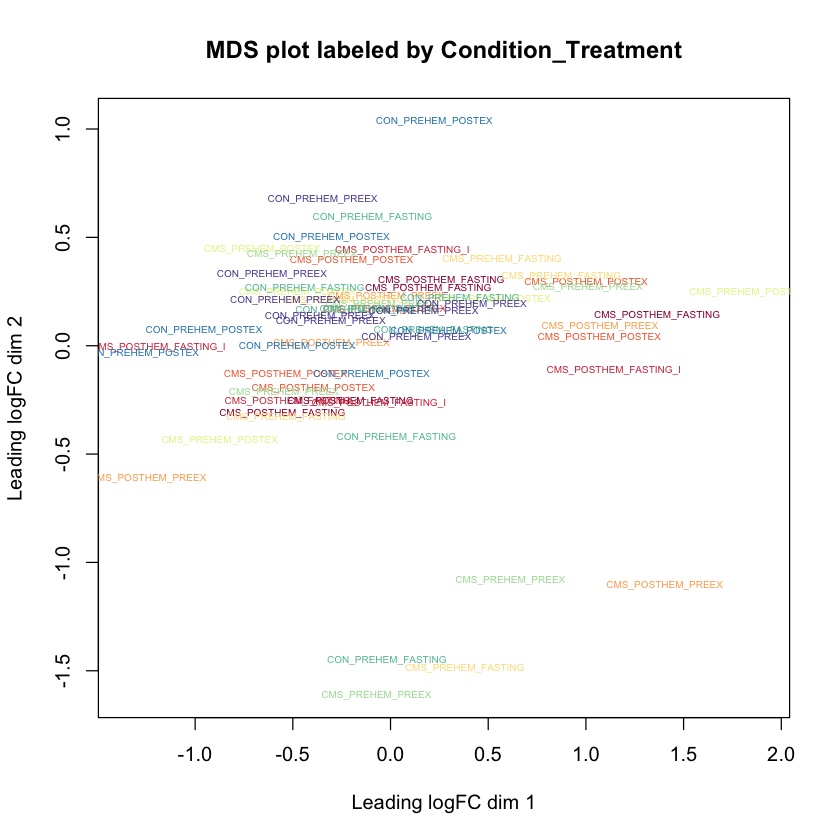

In [37]:
#plotMdsColoredByColumn(gNormedFilteredDgeList, "Treatment", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList, "Condition_Treatment", c(1,2), brewerPaletteName="Spectral")

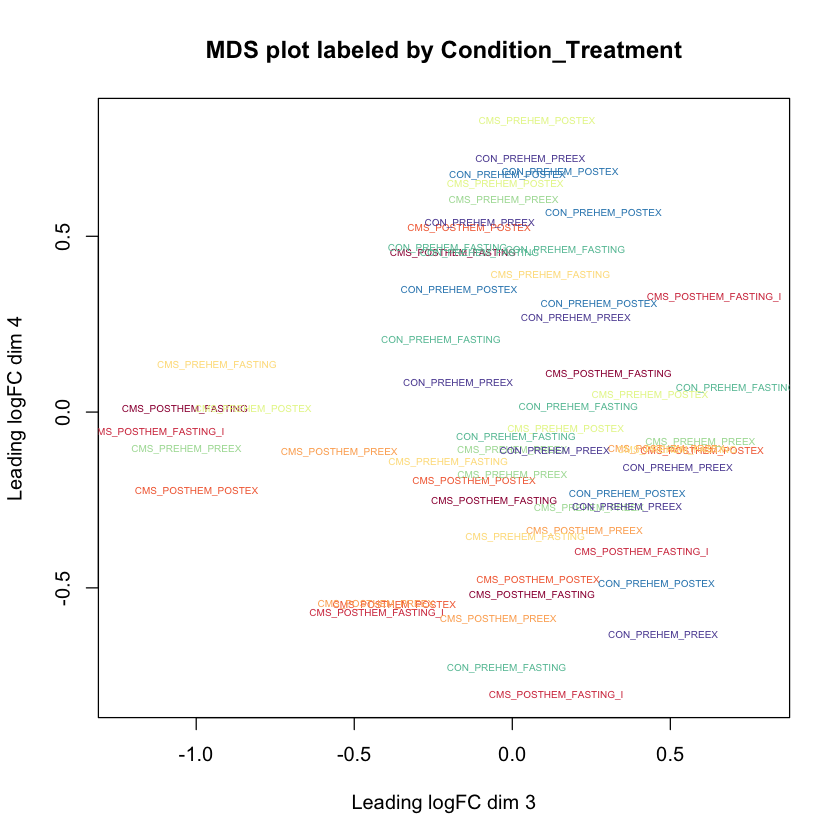

In [38]:
plotMdsColoredByColumn(gNormedFilteredDgeList, "Condition_Treatment", c(3,4), brewerPaletteName="Spectral")

> Some experimental groups, such as "CON_PREHEM_PREEX" and "CON_PREHEM_POSTEX" show decent separation and clustering.

### Interactive MDS plot
The Glimma package ([9](#Citations)) offers the convenience of an interactive MDS plot where multiple dimensions can be explored. The glMDSPlot function generates an html page with an MDS plot in the left panel and a barplot showing the proportion of variation explained by each dimension in the right panel. Clicking on the bars of the bar plot changes the pair of dimensions plotted in the MDS plot, and hovering over the individual points reveals the sample label. 

In [39]:
print(data.frame("column" = colnames(gNormedFilteredDgeList$samples)))

                column
1                group
2             lib.size
3         norm.factors
4            File_Name
5          Sample_name
6            Sample_ID
7              Patient
8            Condition
9            Treatment
10 Condition_Treatment
11              Tissue
12      Date_Collected
13        Physio_State
14         Treatment.1
15             Pass_QC
16         cpf_include


In [40]:
gGroupColumns = c(1, 5:10, 13, 14)

In [41]:
glMDSPlot(cpm(gNormedFilteredDgeList, log=TRUE), 
          labels = gNormedFilteredDgeList$samples[[gSampleColName]], 
          groups = gNormedFilteredDgeList$samples[,gGroupColumns], 
          path = gOutputDir,
          html = sprintf("MDS-Plot_%s", gProjectName))

The Glimma plot opens in a new window of the browser; switch to that window to explore the variance futher.  It is also stored in the "glimma-plots" sub-folder of the output directory for future reference.

Save the workspace objects for future reference:

In [42]:
writeWorkspaceImage(gInterimDir, gRunName)

[1] "Output file: 20191108_simonson_rnaseq_data_exploration_20200218092250.RData"


[Table of Contents](#Table-of-Contents)

## Summary



> **Library sizes**
* These numbers are somewhat small, given that the raw fastq files for the samples contained 15.9 to 32.1 million reads each (see primary analysis); the researchers may wish to investigate the cause for this attrition. However, some of these library sizes should be adequate to give gene-level differential expression findings. 

> **Removal of low-alignment samples**
* The following samples were excluded because they did not meet the 10M reads per sample threshold: S1, S8, S9

> **Raw counts visualization observations**
* Normalization is necessary.

> **Genes filtered due to no/low counts**
* Approximately 521 of the genes in the dataset are missing from reads found in samples (that is, not found to be expressed in any of the samples). 
*  Discarding lowly expressed genes reduces the number of genes in the dataset from 19922 to 13450.

> **CPM threshold**
* Genes having a CPM of greater than 1 for greater than or equal to 5 samples (chosen as this is the smallest group size in this experiment) will be retained for further analysis, while all others will be discarded.

> **Notes on normalization**
> This indicates that normalization appears to have removed library size as a driver in the clustering of the data. The PCA plot doesn't show distinct clusters by condition-treatment groups.

> **Removal of outliers**
* No outliers were removed from the analysis.

>**Notes on MDS plots**
* Some experimental groups, such as "CON_PREHEM_PREEX" and "CON_PREHEM_POSTEX" show decent separation and clustering.


[Table of Contents](#Table-of-Contents)

## Citations

1. Law CW, Alhamdoosh M, Su S, Smyth GK, Ritchie ME. RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR. Version 2. F1000Res. 2016 Jun 17 [revised 2016 Jan 1];5:1408.
2. Ritchie, ME, Phipson, B, Wu, D, Hu, Y, Law, CW, Shi, W, and Smyth, GK (2015). limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Research 43(7), e47.
3. Robinson MD, McCarthy DJ and Smyth GK (2010). edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics 26, 139-140.
4. Huber W, Carey VJ, Gentleman R, Anders S, Carlson M, Carvalho BS, Bravo HC, Davis S, Gatto L, Girke T, Gottardo R, Hahne F, Hansen KD, Irizarry RA, Lawrence M, Love MI, MacDonald J, Obenchain V, Oleś AK, Pagès H, Reyes A, Shannon P, Smyth GK, Tenenbaum D, Waldron L, Morgan M. Orchestrating high-throughput genomic analysis with Bioconductor. Nat Methods. 2015 Feb;12(2):115-21.
5. R Core Team (2016). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.
6. https://support.bioconductor.org/p/69433/#69441
7. Dillies MA, Rau A, Aubert J, Hennequet-Antier C, Jeanmougin M, Servant N, Keime C, Marot G, Castel D, Estelle J, Guernec G, Jagla B, Jouneau L, Laloë D, Le Gall C, Schaëffer B, Le Crom S, Guedj M, Jaffrézic F; French StatOmique Consortium. A comprehensive evaluation of normalization methods for Illumina high-throughput RNA sequencing data analysis. Brief Bioinform. 2013 Nov;14(6):671-83.
8. Robinson MD, Oshlack A. A scaling normalization method for differential expression analysis of RNA-seq data. Genome Biol. 2010;11(3):R25.
9. Su S, Law CW, Ah-Cann C, Asselin-Labat M, Blewitt ME, Ritchie ME (2017). Glimma: interactive graphics for gene expression analysis. Bioinformatics, 33(13), 2050-2052.

[Table of Contents](#Table-of-Contents)

## Appendix: R Session Info

In [43]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] RColorBrewer_1.1-2 ggplot2_3.2.1      cowplot_1.0.0      IRdisplay_0.7.0   
[5] Glimma_1.10.1      edgeR_3.24.3       limma_3.38.3      

loaded via a namespace (and not attached):
 [1] Biobase_2.42.0              httr_1.4.1                 
 [3] bit64_0.9-7                 jsonlite_1.6               
 [5] assertthat_0.2.1            BiocManager_1.30.10        
 [7] stats4_3.5.2                RBGL_1.58.2                
 [9] blob_1.2.0                  GenomeInfoDbData_1.2.0

[Table of Contents](#Table-of-Contents)

Copyright (c) 2018 UC San Diego Center for Computational Biology & Bioinformatics under the MIT License

Notebook template by Amanda Birmingham